In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sklearn.datasets
import umap
import umap.plot
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt
import pandas as pd
from era_data import TabletEraDataset
from era_model import EraClassifier
from era_data import TabletPeriodDataset
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm, trange
from glob import glob


In [2]:
data, labels = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
mapper = umap.UMAP(random_state=42).fit(data)


<AxesSubplot:>

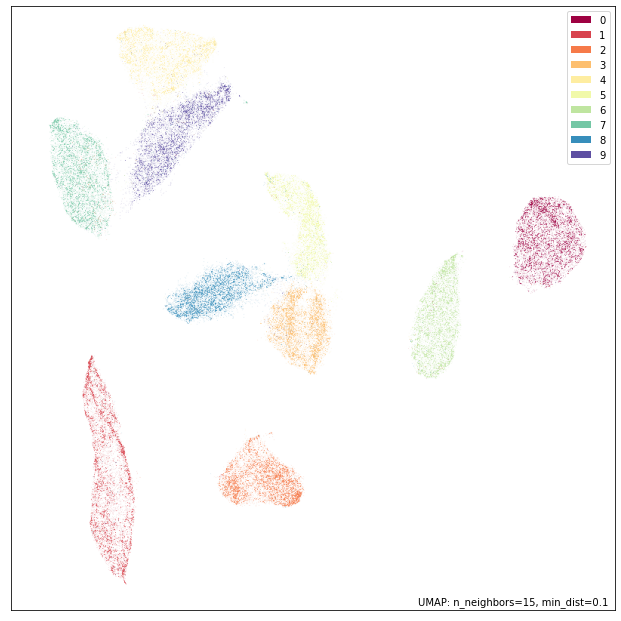

In [4]:
umap.plot.points(mapper, labels=labels)


In [12]:
corners = np.array([
    [-2, -5],  # 1
    [-4, 12],  # 7
    [5, -3],  # 2
    [15, 10],  # 0
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

In [13]:
inv_transformed_points = mapper.inverse_transform(test_pts)


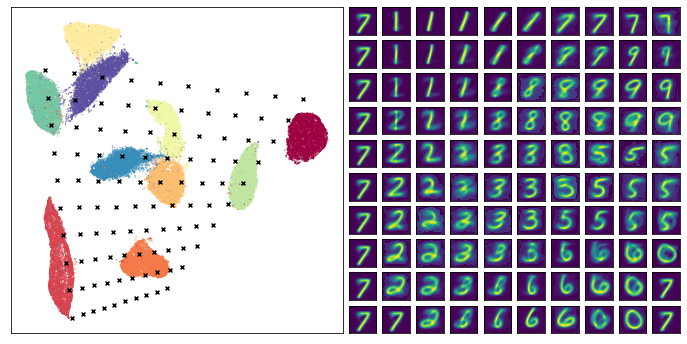

In [14]:
# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=labels.astype(np.int32), cmap='Spectral', s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(28, 28))
        digit_axes[i, j].set(xticks=[], yticks=[])

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
def extract_features(dl, MAX_N=None):
    outs = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            model(X.to(device))
            outs.append(activation['ap'].cpu().numpy()[..., 0, 0])
    return np.vstack(outs)

In [18]:
VERSION_NAME = 'period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked'
IMG_DIR = 'output/images_preprocessed'
CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked/checkpoints/epoch=0-step=6070.ckpt'

In [19]:
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERSION_NAME}.csv', header=None)[0].astype(str)

In [20]:
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR, mask=True)

Filtering 97640 IDS down to provided 500...


In [21]:
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [22]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES) + 2

In [23]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN, num_classes=num_classes)

CPU times: user 1.02 s, sys: 331 ms, total: 1.35 s
Wall time: 6.09 s


In [24]:
model.to(device);

In [11]:
activation = {}
def get_activation(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [12]:
feats = extract_features(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

KeyError: 'ap'

In [ ]:
%time F2 = Isomap(n_components=10).fit_transform(feats)

In [ ]:
feats = extract_features(dl_test)